# BinWaves example in Cantabria (Validation)

**In this notebook**: 
<br><br>
Here waves are reconstructed at the buoy location for comparison.
<br><br>
Steps:
- Buoy is loaded.
- Kp propagation coefficients and hindcast reconstruction is made at the buoy location.
- Comparison plots and statistics are shown.

In [1]:
import pandas as pd
import xarray as xr

# Load buoy data and kps

buoy_waves = pd.read_pickle("outputs/buoy_bulk_parameters.pkl").sort_index().loc["2010-01"]

kp_coeffs = xr.open_dataset("outputs/kp_coefficients.nc").isel(site=[-1])
kp_coeffs

<xarray.Dataset> Size: 2MB
Dimensions:   (case_num: 406, site: 1, freq: 31, dir: 24)
Coordinates:
  * case_num  (case_num) int64 3kB 0 1 2 3 4 5 6 ... 399 400 401 402 403 404 405
  * site      (site) int64 8B 286
  * freq      (freq) float64 248B 0.03 0.0329 0.0362 ... 0.4145 0.4552 0.5
  * dir       (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
    utm_x     (site) float64 8B ...
    utm_y     (site) float64 8B ...
Data variables:
    kps       (case_num, site, freq, dir) float64 2MB ...

In [2]:
kp_coeffs.utm_x.values, kp_coeffs.utm_y.values

(array([428845.1]), array([4815606.89]))

In [3]:
from utils.operations import transform_ERA5_spectrum

model_parameters = pd.read_csv("CAN_cases/swan_cases.csv").to_dict(orient="list")

# Load interest spectra

offshore_spectra, offshore_spectra_case = (
    transform_ERA5_spectrum(
        era5_spectrum=xr.open_dataset("outputs/ERA5_offshore_spectra.nc"),
        subset_parameters=model_parameters,
        available_case_num=kp_coeffs.case_num.values,
    )
)
offshore_spectra_case

<xarray.DataArray 'efth' (case_num: 406, time: 17520)> Size: 57MB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.04577357e-05, 4.08553964e-05, 4.19816247e-05, ...,
        5.65294200e-05, 5.74575032e-05, 6.00530407e-05],
       [2.36402132e-05, 2.40673541e-05, 2.47308005e-05, ...,
        3.69458498e-05, 3.69161785e-05, 3.82645980e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.14144622e-05, 2.12261527e-05, 2.19957586e-05]])
Coordinates:
  * case_num   (case_num) int64 3kB 0 1 2 3 4 5 6 ... 400 401 402 403 404 405
    longitude  float32 4B 356.1
    latitude   float32 4B 43.82
  * time       (time) datetime64[ns] 140kB 2009-01-01 ... 2010-12-31T23:00:00

In [4]:
from bluemath_tk.waves.binwaves import reconstruc_spectra

# Reconstruct spectra

reconstructed_onshore_spectra = reconstruc_spectra(
    offshore_spectra=offshore_spectra_case.sel(time=buoy_waves.index, method="nearest"),
    kp_coeffs=kp_coeffs,
)
reconstructed_onshore_spectra

<xarray.Dataset> Size: 4MB
Dimensions:    (site: 1, freq: 31, dir: 24, time: 744)
Coordinates:
  * site       (site) int64 8B 286
  * freq       (freq) float64 248B 0.03 0.0329 0.0362 ... 0.4145 0.4552 0.5
  * dir        (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
    utm_x      (site) float64 8B 4.288e+05
    utm_y      (site) float64 8B 4.816e+06
    longitude  float32 4B 356.1
    latitude   float32 4B 43.82
  * time       (time) datetime64[ns] 6kB 2010-01-01 ... 2010-01-31T23:00:00
Data variables:
    kps        (time, site, freq, dir) float64 4MB 0.0 0.0 ... 1.291e-05

/opt/conda/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:512: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)
/opt/conda/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:512: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)


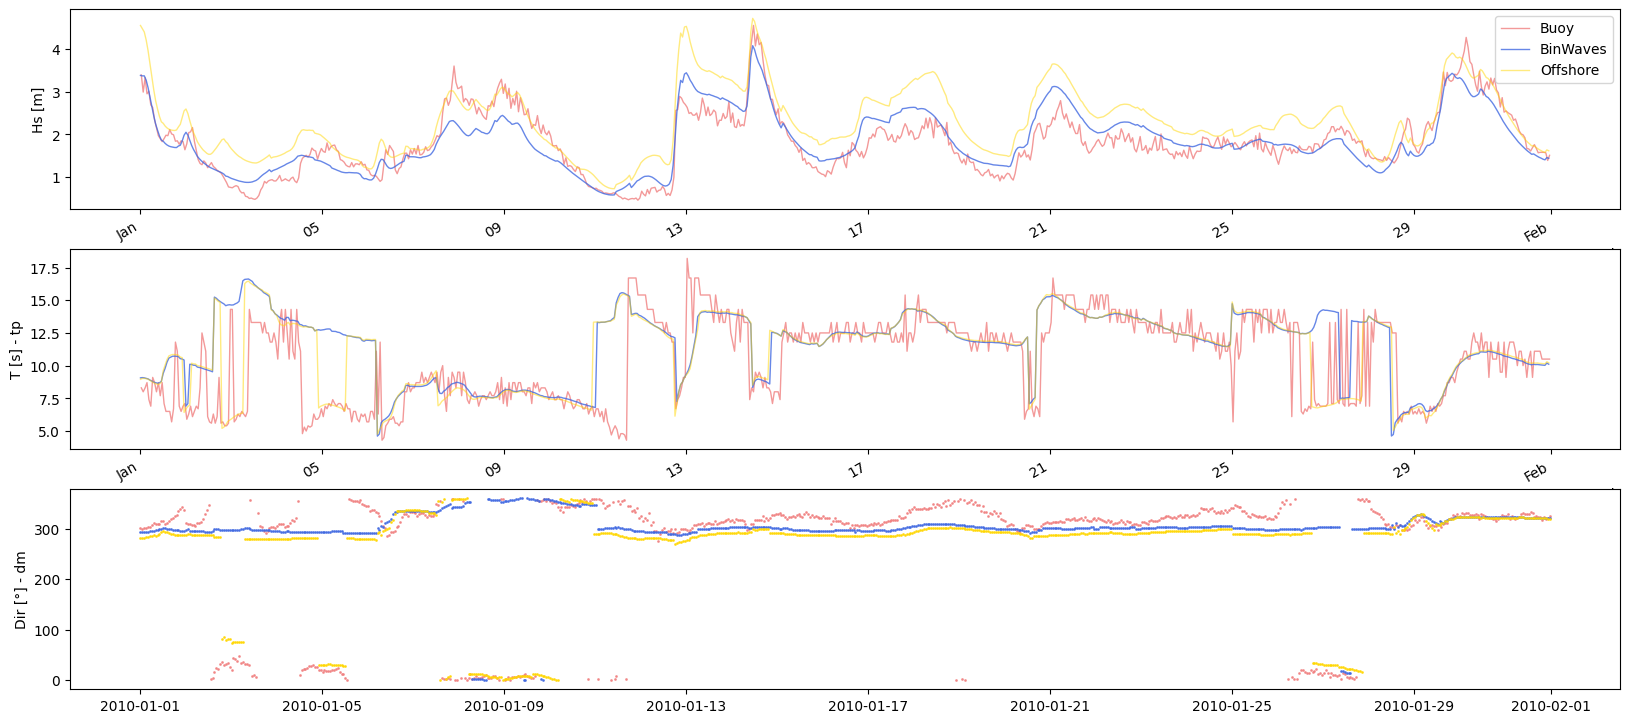

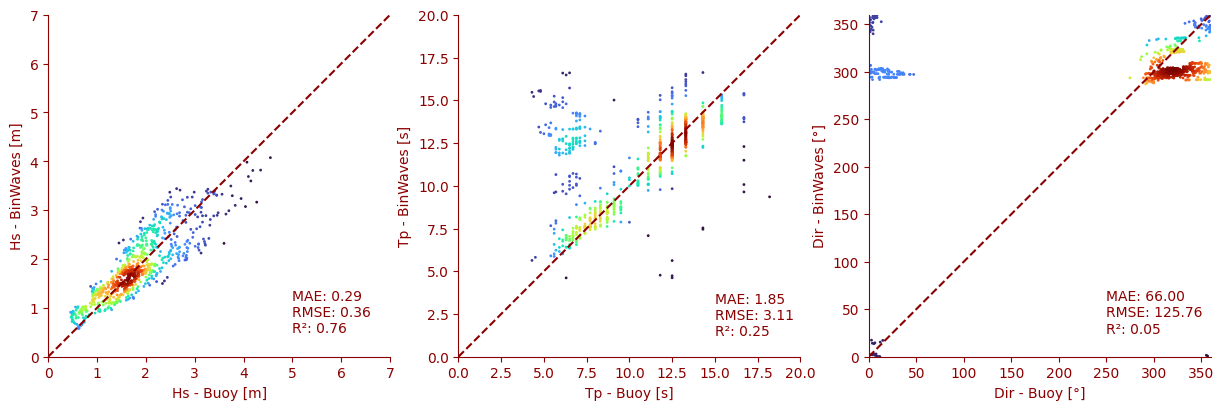

: 

In [ ]:
from utils.plotting import plot_wave_series

# Plot reconstructed bulk parameters vs buoy data

plot_wave_series(
    buoy_data=buoy_waves,
    binwaves_data=reconstructed_onshore_spectra.rename({"kps": "efth"})
    .squeeze()
    .sel(time=buoy_waves.index, method="nearest")
    .spec,
    offshore_data=offshore_spectra.sel(time=buoy_waves.index, method="nearest").spec,
    times=buoy_waves.index.values,
);